In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="6"

Thu May 25 02:15:50 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.105.01   Driver Version: 515.105.01   CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A5000    Off  | 00000000:1B:00.0 Off |                    0 |
| 30%   27C    P8    17W / 230W |    369MiB / 23028MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA RTX A5000    Off  | 00000000:1C:00.0 Off |                  Off |
| 30%   

### Hyperparams

In [4]:
n_mels = 32
n_outputs = 61
n_frames = 400
sr = 24000
fps = 30
train_csv_files = ['/Storage/speech/face/rvh_viseme2_1_iPhone_raw_30fps.csv',
                   '/Storage/speech/face/rvh_viseme2_2_iPhone_raw_30fps.csv',
                   '/Storage/speech/face/rvh_viseme2_3_iPhone_raw_30fps.csv',
                   '/Storage/speech/face/rvh_viseme2_4_iPhone_raw_30fps.csv',
                  ]
train_wav_files = ['/Storage/speech/face/rvh_viseme2_1_iPhone.wav',
                   '/Storage/speech/face/rvh_viseme2_2_iPhone.wav',
                   '/Storage/speech/face/rvh_viseme2_3_iPhone.wav',
                   '/Storage/speech/face/rvh_viseme2_4_iPhone.wav',
                  ]

test_csv_files = ['/Storage/speech/face/MySlate_6_박수철의_iPhone_30fps.csv']
test_wav_files = ['/Storage/speech/face/MySlate_6_박수철의_iPhone.wav']

### Model

In [5]:
from model.model_reg import Model
from utils.util import *
from tensorboardX import SummaryWriter

step = 0
device = 'cuda:0'

# Model
model = Model(in_dim=n_mels, out_dim=n_outputs)
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
print('done')

done


### Load

In [7]:
save_dir = '/data/scpark/save/lips/train05.19-8/'
!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, model, _, optimizer = load(save_dir, 13000, model, None, optimizer)

total 0
-rw-rw-r-- 1 scpark scpark 0  5월 25 02:16 events.out.tfevents.1684948570.GPUSVR01


In [8]:
import torch
from data.dataset import LipsDataset, Collate

train_dataset = LipsDataset(train_wav_files, train_csv_files, n_frames, n_mels=n_mels, sr=sr, fps=fps, perturb=True)
print('train dataset :', len(train_dataset))
train_loader = torch.utils.data.DataLoader(train_dataset, num_workers=1, shuffle=True, batch_size=8, 
                                           collate_fn=Collate(n_frames, n_mels))
print(train_loader)

test_dataset = LipsDataset(test_wav_files, test_csv_files, n_frames, n_mels=n_mels, sr=sr, fps=fps, perturb=False)
print('test dataset :', len(test_dataset))
test_loader = torch.utils.data.DataLoader(test_dataset, num_workers=1, shuffle=True, batch_size=8,
                                           collate_fn=Collate(n_frames, n_mels))
print(test_loader)

train dataset : 28308
test dataset : 1413


test : 0 0.0744861364364624
test : 1 0.07483457773923874
test : 2 0.07528798282146454
test : 3 0.07663688063621521
test : 4 0.07623932510614395
test : 5 0.0772332027554512
test : 6 0.07637771219015121
test : 7 0.0763661116361618
test : 8 0.07721996307373047
test : 9 0.07583776116371155
test_loss : 0.0760519728064537


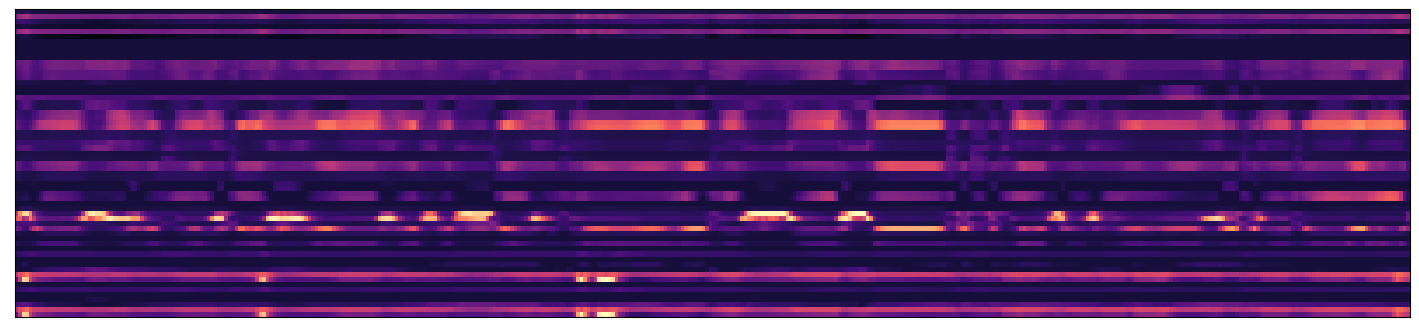

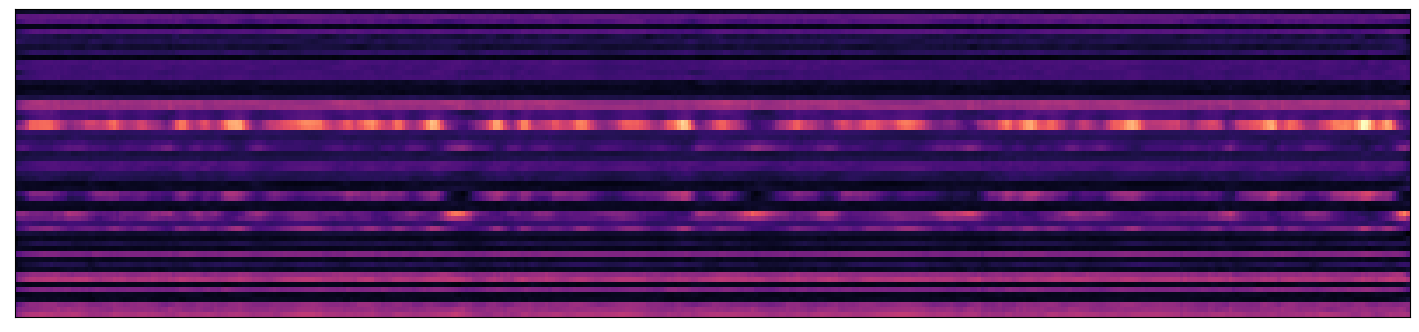

201
loss 0.02708042412996292
201 0.02708042412996292
202
loss 0.026187794283032417
202 0.026187794283032417
203
loss 0.028349539265036583
203 0.028349539265036583
204
loss 0.02894243411719799
204 0.02894243411719799
205
loss 0.026360534131526947
205 0.026360534131526947
206
loss 0.026826119050383568
206 0.026826119050383568
207
loss 0.027674799785017967
207 0.027674799785017967
208
loss 0.027950551360845566
208 0.027950551360845566
209
loss 0.026818662881851196
209 0.026818662881851196
210
loss 0.02870073728263378
210 0.02870073728263378
211
loss 0.02956249564886093
211 0.02956249564886093
212
loss 0.028081540018320084
212 0.028081540018320084
213
loss 0.02681100368499756
213 0.02681100368499756
214
loss 0.031597208231687546
214 0.031597208231687546
215
loss 0.029799824580550194
215 0.029799824580550194
216
loss 0.027867481112480164
216 0.027867481112480164
217
loss 0.02776368148624897
217 0.02776368148624897
218
loss 0.027085641399025917
218 0.027085641399025917
219
loss 0.02808401733

In [ ]:
from IPython import display
import librosa.display
import matplotlib.pyplot as plt

isnan = False
while True:
    if isnan:
        break
    for batch in train_loader:
        inputs = batch['inputs'].transpose(1, 2).to(device)
        targets = batch['outputs'].transpose(1, 2).to(device)
        
        model.train()
        model.zero_grad()
        outputs = model(inputs, targets)
        
        print(step)
        loss = 0
        for key in outputs.keys():
            if 'loss' in key:
                loss += outputs[key]
                print(key, outputs[key].item())
        if torch.isnan(loss):
            isnan = True
            break
        loss.backward()
        optimizer.step()
        print(step, loss.item())
        
        if step % 100 == 0:
            writer.add_scalar('train_loss', loss.item(), step)
        
        if step % 100 == 0:
            display.clear_output()
            
            losses = []
            for i, batch in enumerate(test_loader):
                if i >= 10:
                    break
                    
                inputs = batch['inputs'].transpose(1, 2).to(device)
                targets = batch['outputs'].transpose(1, 2).to(device)

                model.eval()
                with torch.no_grad():
                    outputs = model(inputs, targets)
                    
                loss = 0
                for key in outputs.keys():
                    if 'loss' in key:
                        loss += outputs[key]
                print('test :', i, loss.item())
                losses.append(loss)        
            
            test_loss = torch.stack(losses).mean().item()
            print('test_loss :', test_loss)
            writer.add_scalar('test_loss', test_loss, step)
            
            plt.figure(figsize=[18, 4])
            librosa.display.specshow(targets[0].data.cpu().numpy(), cmap='magma')
            plt.show()

            plt.figure(figsize=[18, 4])
            librosa.display.specshow(outputs['y_pred'][0].data.cpu().numpy(), cmap='magma')
            plt.show()

        if step % 1000 == 0:
            save(save_dir, step, model, None, optimizer)
    
        step += 1

In [ ]:
save(save_dir, step, model, None, optimizer)